<a href="https://colab.research.google.com/github/KoreTane/Analise-GLP/blob/main/An%C3%A1lisePre%C3%A7oGLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!pip install folium geopandas
!pip install requests

In [2]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import make_interp_spline
from pyspark.sql.functions import year, month, count, avg, sum, to_date, col
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

drive.mount('/content/drive')

spark = SparkSession.builder \
    .appName("Análise de Preços do GLP") \
    .getOrCreate()

# Caminho para a pasta no Google Drive onde os arquivos Parquet estão armazenados
#(convertemos anteriormente do formato CVS => parquet para melhoramos a eficiência de armazenamento e a velocidade de leitura
# permitindo análises mais rápidas e economizando espaço em disco)

parquet_folder_path = '/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/'

# Carregando o arquivo Excel
localizacao_df = pd.read_excel('/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/BR_Localidades.xlsx')
localizacao_df = spark.createDataFrame(localizacao_df)

# Lista de arquivos Parquet
parquet_files = [
    'precos-2022-10-glp.parquet',
    'precos-2022-11-glp.parquet',
    'precos-2022-12-glp.parquet',
    'glp2023-01.parquet',
    'glp2023-02.parquet',
    'glp2024-01.parquet',
   'precosglp2024-07.parquet',
    'precosglp2024-08.parquet',
    'precos-glp-09.parquet'
]

parquet_dataframes = {
    file: spark.read.parquet(f'{parquet_folder_path}{file}')
    for file in parquet_files
}

union_df = (
    parquet_dataframes['precos-2022-10-glp.parquet']
    .union(parquet_dataframes['precos-2022-11-glp.parquet'])
    .union(parquet_dataframes['precos-2022-12-glp.parquet'])
    .union(parquet_dataframes['glp2023-01.parquet'])
    .union(parquet_dataframes['glp2023-02.parquet'])
    .union(parquet_dataframes['glp2024-01.parquet'])
    .union(parquet_dataframes['precosglp2024-07.parquet'])
    .union(parquet_dataframes['precosglp2024-08.parquet'])
    .union(parquet_dataframes['precos-glp-09.parquet'])
)
union_df = union_df.withColumn("id_venda", F.monotonically_increasing_id())


colunas = ['id_venda'] + [col for col in union_df.columns if col != 'id_venda']
union_df = union_df.select(colunas)

print("Dados do DataFrame unido:")
union_df.printSchema()

union_df.describe().show()

union_df.show(10, truncate=False)

localizacao_df.printSchema()

localizacao_df.describe().show()

Mounted at /content/drive
Dados do DataFrame unido:
root
 |-- id_venda: long (nullable = false)
 |-- Regiao - Sigla: string (nullable = true)
 |-- Estado - Sigla: string (nullable = true)
 |-- Municipio: string (nullable = true)
 |-- Revenda: string (nullable = true)
 |-- CNPJ da Revenda: string (nullable = true)
 |-- Nome da Rua: string (nullable = true)
 |-- Numero Rua: string (nullable = true)
 |-- Complemento: string (nullable = true)
 |-- Bairro: string (nullable = true)
 |-- Cep: string (nullable = true)
 |-- Produto: string (nullable = true)
 |-- Data da Coleta: string (nullable = true)
 |-- Valor de Venda: string (nullable = true)
 |-- Valor de Compra: string (nullable = true)
 |-- Unidade de Medida: string (nullable = true)
 |-- Bandeira: string (nullable = true)

+-------+--------------------+--------------+--------------+----------+--------------------+-------------------+--------------------+------------------+-----------------+--------------+---------+-------+-------------

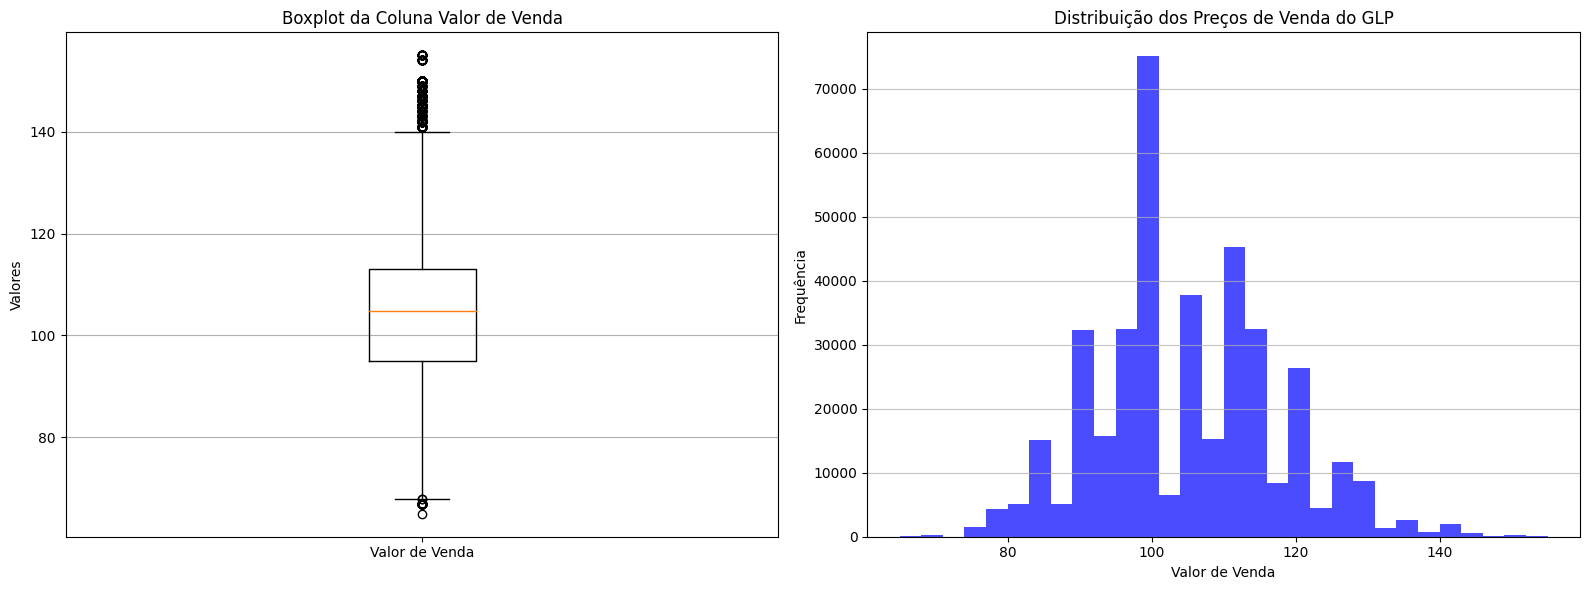

In [3]:
# Função para converter valores monetários para float
def convert_to_float(value):
    if isinstance(value, str):
        return float(value.replace(',', '.'))
    return value

# Convert PySpark DataFrame to Pandas DataFrame
union_df_pd = union_df.toPandas()

# Converter a coluna 'Valor de Venda'
union_df_pd['Valor de Venda'] = union_df_pd['Valor de Venda'].apply(convert_to_float)
union_df_pd['Valor de Venda'] = pd.to_numeric(union_df_pd['Valor de Venda'], errors='coerce')

# Criar subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
axs[0].boxplot(union_df_pd['Valor de Venda'].dropna())
axs[0].set_title('Boxplot da Coluna Valor de Venda')
axs[0].set_ylabel('Valores')
axs[0].set_xticks([1])
axs[0].set_xticklabels(['Valor de Venda'])
axs[0].grid(axis='y')

# Histograma
axs[1].hist(union_df_pd['Valor de Venda'].dropna(), bins=30, color='blue', alpha=0.7)
axs[1].set_title('Distribuição dos Preços de Venda do GLP')
axs[1].set_xlabel('Valor de Venda')
axs[1].set_ylabel('Frequência')
axs[1].grid(axis='y', alpha=0.75)


plt.tight_layout()
plt.show()

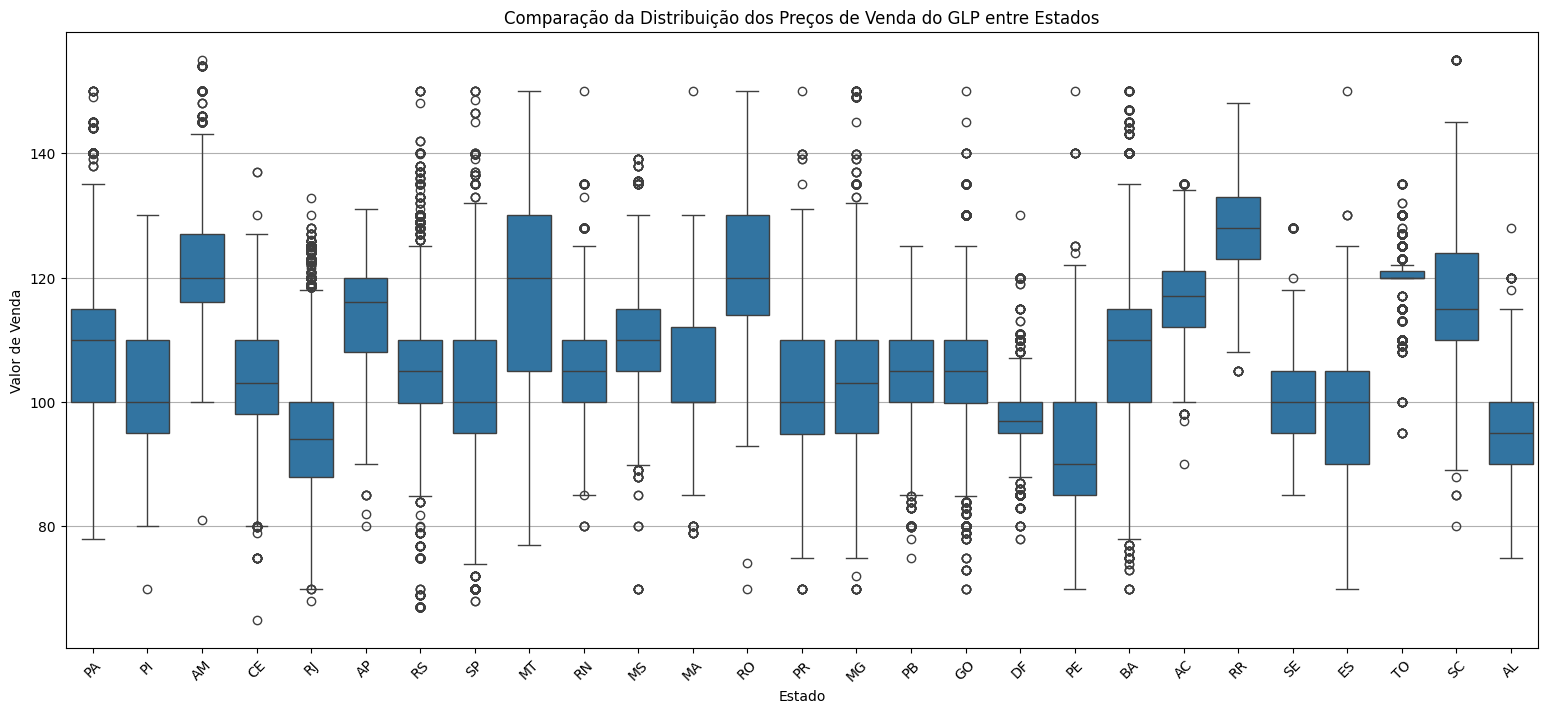

In [4]:
# Boxplot para comparar preços entre estados
plt.figure(figsize=(19, 8))
sns.boxplot(x='Estado - Sigla', y='Valor de Venda', data=union_df_pd)
plt.title('Comparação da Distribuição dos Preços de Venda do GLP entre Estados')
plt.xlabel('Estado')
plt.ylabel('Valor de Venda')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

In [5]:
# TRATAMENTO DOS DADOS
# Completar valores nulos na coluna 'Complemento'
union_df = union_df.fillna('Não Informado', subset=['Complemento'])

# Remover as colunas especificadas que não fazem sentido para o modelo
colunas_a_remover = ['Valor de Compra', 'Produto', 'Unidade de Medida', 'CNPJ da Revenda']
union_df = union_df.drop(*colunas_a_remover)

# Remover linhas onde "Valor de Venda" está em branco ou nulo
union_df = union_df.filter(col("Valor de Venda").isNotNull() & (col("Valor de Venda") != ""))
# Convertendo a coluna 'Data da Coleta' para o tipo de data
union_df = union_df.withColumn("Data da Coleta", to_date(union_df["Data da Coleta"], "dd/MM/yyyy"))
union_df = union_df.withColumn("Ano", year(union_df["Data da Coleta"]))

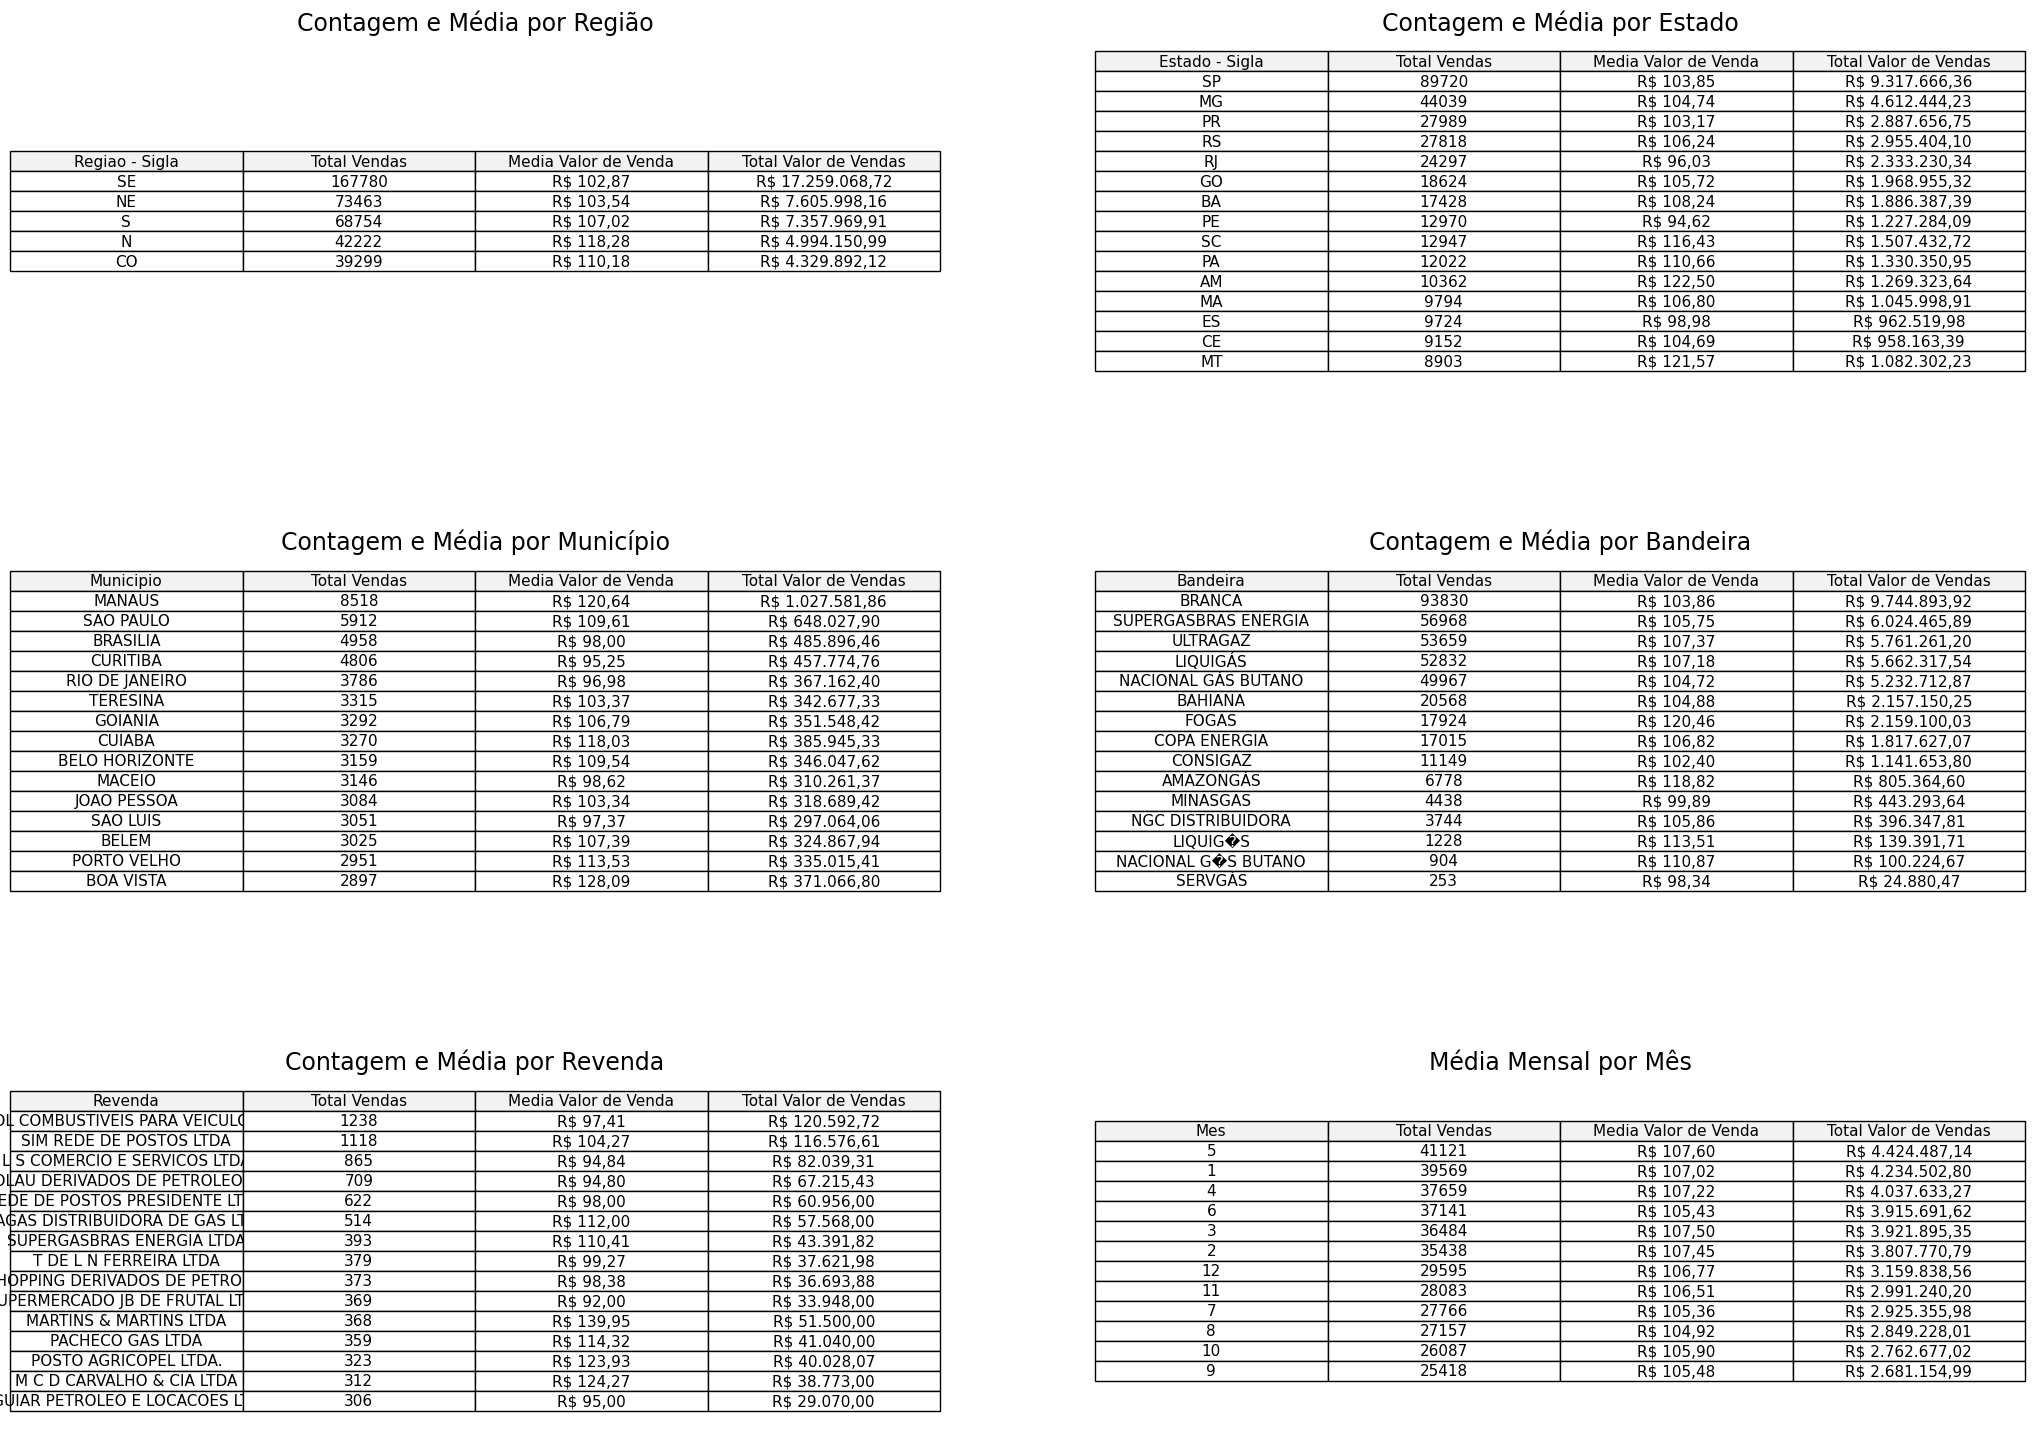

In [6]:
# Agrupando e calculando os totais para cada categoria
region_count_pd = union_df.groupBy("Regiao - Sigla").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")
).toPandas()

state_count_pd = union_df.groupBy("Estado - Sigla").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")
).toPandas()

municipio_count_pd = union_df.groupBy("Municipio").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")
).toPandas()

bandeira_count_pd = union_df.groupBy("Bandeira").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")
).toPandas()

# Agrupando os dados por Revenda e calculando os totais
revenda_count_pd = union_df.groupBy("Revenda").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")
).toPandas()

# Agrupando os dados por mês e calculando os totais
data_count_pd = union_df.groupBy(month(union_df["Data da Coleta"]).alias('Mes')).agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")
).toPandas()

# Formatar os valores monetários
for df in [region_count_pd, state_count_pd, municipio_count_pd, bandeira_count_pd, revenda_count_pd, data_count_pd]:
    df["Media Valor de Venda"] = df["Media Valor de Venda"].apply(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
    df["Total Valor de Vendas"] = df["Total Valor de Vendas"].apply(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Criar uma figura com subplots
fig, axs = plt.subplots(3, 2, figsize=(24, 18))

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Definindo os parâmetros para as tabelas
tables_info = [
    (region_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Região"),
    (state_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Estado"),
    (municipio_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Município"),
    (bandeira_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Bandeira"),
    (revenda_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Revenda"),
    (data_count_pd.sort_values(by="Total Vendas", ascending=False), "Média Mensal por Mês")
]

# Loop para exibir os resultados nas subplots
for ax, (data, title) in zip(axs.flatten(), tables_info):
    if not data.empty:
        ax.axis('off')
        ax.set_title(title, fontsize=17)


        table_data = data[['Regiao - Sigla', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Regiao - Sigla' in data.columns else \
                     data[['Estado - Sigla', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Estado - Sigla' in data.columns else \
                     data[['Municipio', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Municipio' in data.columns else \
                     data[['Bandeira', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Bandeira' in data.columns else \
                     data[['Revenda', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Revenda' in data.columns else \
                     data[['Mes', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']]

        table = ax.table(cellText=table_data.head(15).values,
                         colLabels=table_data.columns,
                         cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(table_data.columns))
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.2)
    else:
        ax.axis('off')  # Desativa o eixo para subplots vazios


plt.show()

In [7]:
revenda_info = union_df.filter(union_df["Revenda"] == "SIM REDE DE POSTOS LTDA").agg(
    count("id_venda").alias("Total Vendas")
).toPandas()

print(revenda_info)

   Total Vendas
0          1118


In [8]:
## Juntar union_df com localizacao_df para obter latitudes e longitudes (utilizamos a base de cadastro de municipios do IBGE para pegar a LAT e LONG)
merged_df = union_df.join(localizacao_df, union_df["Municipio"] == localizacao_df["NM_MUNICIPIO"], "inner")

# Calcular o total de vendas por município
vendas_por_municipio = merged_df.groupBy("NM_MUNICIPIO", "LONG", "LAT").agg(
    F.count("id_venda").alias("Total Vendas")
).toPandas()  # Convertendo para Pandas para facilitar a manipulação

# Criar o Mapa de Calor
mapa = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)  # Centro do Brasil

# Adicionar os pontos ao mapa
heat_data = [[row['LAT'], row['LONG'], row['Total Vendas']] for index, row in vendas_por_municipio.iterrows()]
HeatMap(heat_data).add_to(mapa)

# Salvar o mapa em um arquivo HTML
mapa.save("mapa_calor_vendas.html")
mapa

In [9]:
# Exportando o DataFrame union_df para um arquivo CSV para dar aquela checadinha esporadicamente  se está tudo okkk
#output_path = "union_df2.csv"

# Escrevendo o DataFrame em formato CSV com uma única partição
#union_df.coalesce(1).write.option("header", "true").csv(output_path)

#print(f"DataFrame exportado com sucesso para {output_path}")

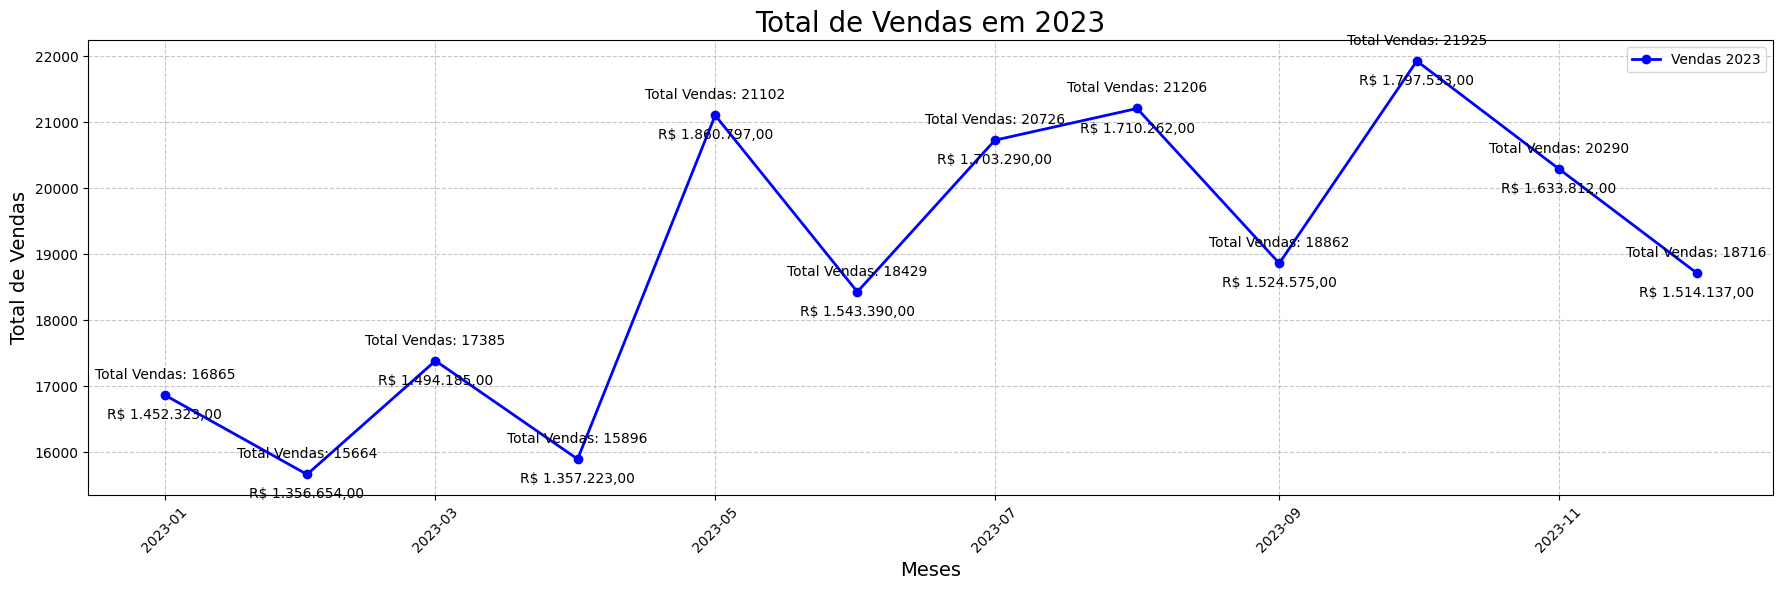

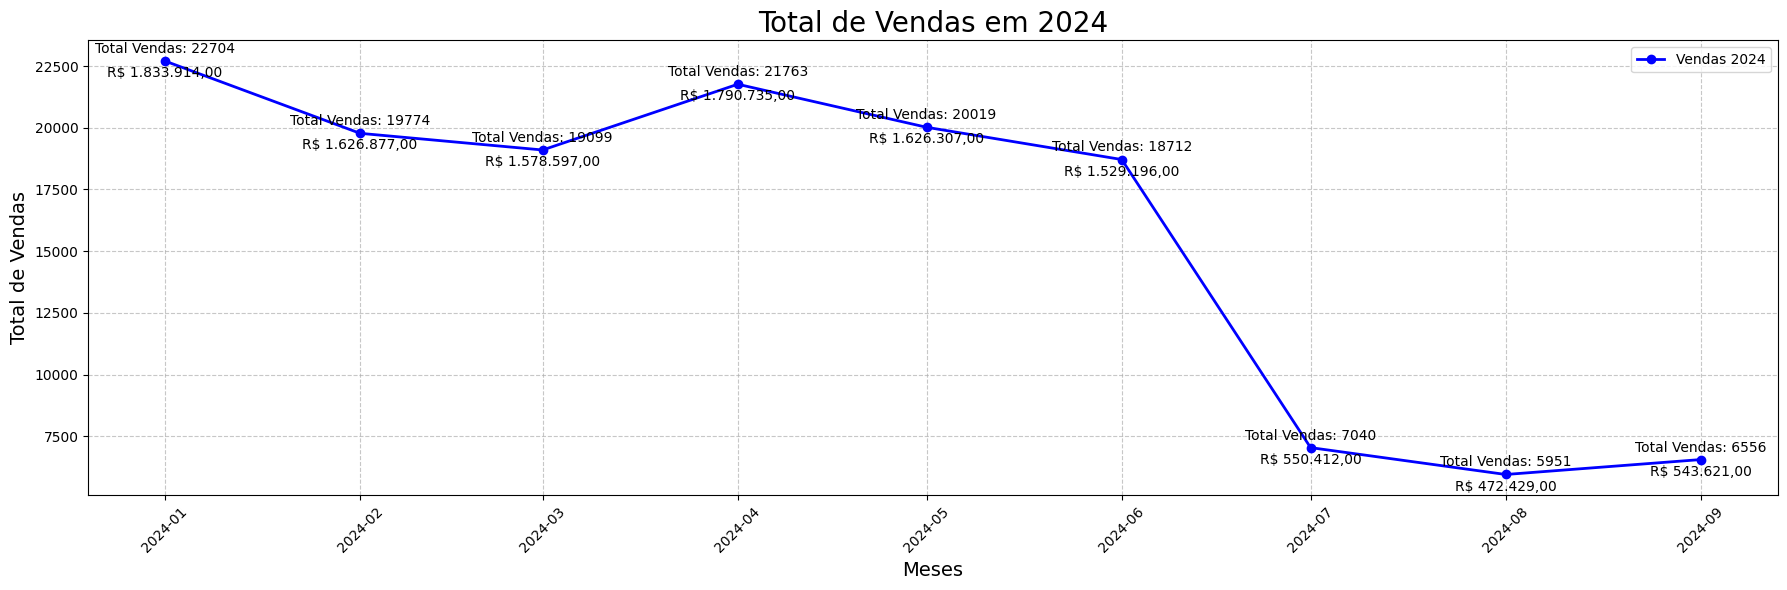

In [10]:
# Função para formatar valores monetários
def formatar_valor(valor):
    return f"R$ {valor:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

# Função para criar gráfico de vendas em linha com rótulos
def plot_vendas_linha(vendas_pd, ano):
    x = vendas_pd['Data']
    y = vendas_pd['Total_Vendas']
    valor_venda = vendas_pd['Valor_Venda']  # Coluna correta

    plt.figure(figsize=(18, 6))

    # Gráfico de linha
    plt.plot(x, y, marker='o', label=f'Vendas {ano}', color='blue', linewidth=2)
    plt.title(f'Total de Vendas em {ano}', fontsize=20)
    plt.xlabel('Meses', fontsize=14)
    plt.ylabel('Total de Vendas', fontsize=14)

    # Formatar o eixo x para mostrar apenas os meses
    plt.xticks(rotation=45)

    # Adicionando grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adicionar rótulos com o número total de vendas e valor total formatado
    for i in range(len(y)):
        total_valor = valor_venda[i]  # Usar diretamente o valor da venda

        # Ajuste dinâmico da posição dos rótulos para evitar sobreposição
        offset = 0.009 * max(y)  # Reduzindo a altura do deslocamento

        # Rótulo com o número de vendas
        plt.text(x[i], y[i] + offset, f'Total Vendas: {y[i]}', ha='center', va='bottom')

        # Rótulo com o valor total formatado
        plt.text(x[i], y[i] - offset, formatar_valor(total_valor), ha='center', va='top')

    # Ajustes finais
    plt.legend()
    plt.tight_layout()
    plt.show()

# Filtrar e agrupar dados para 2023
vendas_2023 = union_df.filter(union_df['Ano'] == 2023) \
    .withColumn('Mes', F.month(union_df['Data da Coleta'])) \
    .groupBy('Mes').agg(
        F.count('id_venda').alias('Total_Vendas'),
        F.sum('Valor de Venda').alias('Valor_Venda')
    ).orderBy('Mes')

vendas_2023_pd = vendas_2023.toPandas()
vendas_2023_pd['Data'] = pd.to_datetime(vendas_2023_pd['Mes'].astype(str) + '-01-2023')

# Filtrar e agrupar dados para 2024
vendas_2024 = union_df.filter(union_df['Ano'] == 2024) \
    .withColumn('Mes', F.month(union_df['Data da Coleta'])) \
    .groupBy('Mes').agg(
        F.count('id_venda').alias('Total_Vendas'),
        F.sum('Valor de Venda').alias('Valor_Venda')
    ).orderBy('Mes')

vendas_2024_pd = vendas_2024.toPandas()
vendas_2024_pd['Data'] = pd.to_datetime(vendas_2024_pd['Mes'].astype(str) + '-01-2024')

# Plotar gráficos separados
plot_vendas_linha(vendas_2023_pd, 2023)
plot_vendas_linha(vendas_2024_pd, 2024)

In [11]:
union_df.show(10)

+--------+--------------+--------------+---------+--------------------+--------------------+----------+--------------------+--------------+---------+--------------+--------------+--------------------+----+
|id_venda|Regiao - Sigla|Estado - Sigla|Municipio|             Revenda|         Nome da Rua|Numero Rua|         Complemento|        Bairro|      Cep|Data da Coleta|Valor de Venda|            Bandeira| Ano|
+--------+--------------+--------------+---------+--------------------+--------------------+----------+--------------------+--------------+---------+--------------+--------------+--------------------+----+
|       0|             N|            PA|    BELEM|AUTO POSTO BELEM ...|AVENIDA PEDRO ALV...|       S/N|ESQ. COM AV. TAVA...|     MARAMBAIA|66613-150|    2022-10-03|           119|SUPERGASBRAS ENERGIA|2022|
|       1|             N|            PA|    BELEM|IRMAOS TEIXEIRA LTDA|AVENIDA PEDRO ALV...|      3800|       Não Informado|    SACRAMENTA|66120-620|    2022-10-03|        115,

In [12]:
# Filtrar os dados de janeiro de 2023 a agosto de 2024
union_df_filtered = union_df.filter((union_df["Data da Coleta"] >= "2022-10-03") & (union_df["Data da Coleta"] <= "2024-09-30"))

# Cast 'Valor de Venda' to a numeric type (e.g., float) before aggregation
union_df_filtered = union_df_filtered.withColumn("Valor de Venda", union_df_filtered["Valor de Venda"].cast("float"))

# Agrupar e calcular a média mensal
union_df_grouped = union_df_filtered.groupBy("Regiao - Sigla", "Estado - Sigla", "Bandeira", "Data da Coleta").avg("Valor de Venda")
union_df_grouped = union_df_grouped.withColumnRenamed("avg(Valor de Venda)", "Media Valor de Venda")

# Transformar a coluna 'Data da Coleta' para ano e mês
union_df_grouped = union_df_grouped.withColumn("AnoMes", union_df_grouped["Data da Coleta"].substr(0, 7))

In [13]:
# Coletar os dados em um DataFrame do Pandas
df_grouped_pd = union_df_grouped.toPandas()

# Pivotar os dados para criar a matriz
df_pivot = df_grouped_pd.pivot_table(index=["Regiao - Sigla", "Estado - Sigla", "Bandeira"], columns="AnoMes", values="Media Valor de Venda")

# Calcular a variação mensal
df_pivot_diff = df_pivot.diff(axis=1)

In [15]:
# Filtrar os dados de janeiro de 2023 a agosto de 2024
union_df_filtered = union_df.filter((union_df["Data da Coleta"] >= "2022-10-03") & (union_df["Data da Coleta"] <= "2024-09-30"))

# Cast 'Valor de Venda' to a numeric type
union_df_filtered = union_df_filtered.withColumn("Valor de Venda", union_df_filtered["Valor de Venda"].cast("float"))

# Agrupar e calcular a média mensal
union_df_grouped = union_df_filtered.groupBy("Regiao - Sigla", "Data da Coleta").avg("Valor de Venda")
union_df_grouped = union_df_grouped.withColumnRenamed("avg(Valor de Venda)", "Media Valor de Venda")

# Transformar a coluna 'Data da Coleta' para ano e mês
union_df_grouped = union_df_grouped.withColumn("AnoMes", union_df_grouped["Data da Coleta"].substr(0, 7))

# Coletar os dados em um DataFrame do Pandas
df_grouped_pd = union_df_grouped.toPandas()

# Pivotar os dados para criar a matriz
df_pivot = df_grouped_pd.pivot_table(index=["Regiao - Sigla"], columns="AnoMes", values="Media Valor de Venda")

# Calcular a variação percentual mensal
df_pivot_diff = df_pivot.pct_change(axis=1) * 100

# Função para adicionar setas indicativas e formatação de variação percentual
def add_arrows_and_percent(data):
    arrow_data = data.copy()
    for i in range(1, data.shape[1]):
        for j in range(data.shape[0]):
            if data.iloc[j, i] > data.iloc[j, i-1]:
                arrow_data.iloc[j, i] = f"↑ {data.iloc[j, i]:.2f}%"
            elif data.iloc[j, i] < data.iloc[j, i-1]:
                arrow_data.iloc[j, i] = f"↓ {data.iloc[j, i]:.2f}%"
            else:
                arrow_data.iloc[j, i] = f"→ {data.iloc[j, i]:.2f}%"
    return arrow_data

# Adicionar setas e formatação percentual
arrows_and_percent = add_arrows_and_percent(df_pivot_diff)

# Transformar o DataFrame para o formato longo para o gráfico percentual
df_long_percent = df_pivot_diff.reset_index().melt(id_vars=["Regiao - Sigla"], var_name="AnoMes", value_name="Variação")


# Criar o gráfico interativo com variação percentual agrupado por região
fig_percent = px.imshow(df_pivot_diff, color_continuous_scale='RdBu_r', aspect='auto')

# Adicionar anotações de setas e variação percentual
annotations_percent = []
for i, row in df_long_percent.iterrows():
    try:
        text = arrows_and_percent.loc[row["Regiao - Sigla"], row["AnoMes"]]
        text = str(text)
    except (KeyError, IndexError):
        text = ''
    annotations_percent.append(dict(
        x=row["AnoMes"],
        y=row["Regiao - Sigla"],
        text=text,
        showarrow=False,
        font=dict(size=12, color="black")
    ))

fig_percent.update_layout(annotations=annotations_percent)
fig_percent.update_layout(
    title=dict(
        text="Variação Preço do Gás",
        font=dict(size=20, color="black", family="Arial", weight="bold"),
        x=0.5,
        xanchor='center'
    )
)
fig_percent.show()

# Criar o gráfico interativo com valores numéricos (sem alteração na estrutura)
fig_value = px.imshow(df_pivot, color_continuous_scale='RdBu_r', aspect='auto')

# Adicionar anotações de valores numéricos diretamente do DataFrame pivotado
annotations_value = []
for region in df_pivot.index:
    for month in df_pivot.columns:
        value_text = df_pivot.at[region, month]
        annotations_value.append(dict(
            x=month,
            y=region,
            text=f"{value_text:.2f}",
            showarrow=False,
            font=dict(size=12, color="black")
        ))

fig_value.update_layout(annotations=annotations_value)
fig_value.update_layout(
    title=dict(
        text="Variação Numerica",
        font=dict(size=20, color="black", family="Arial", weight="bold"),
        x=0.5,
        xanchor='center'
    )
)
fig_value.show()

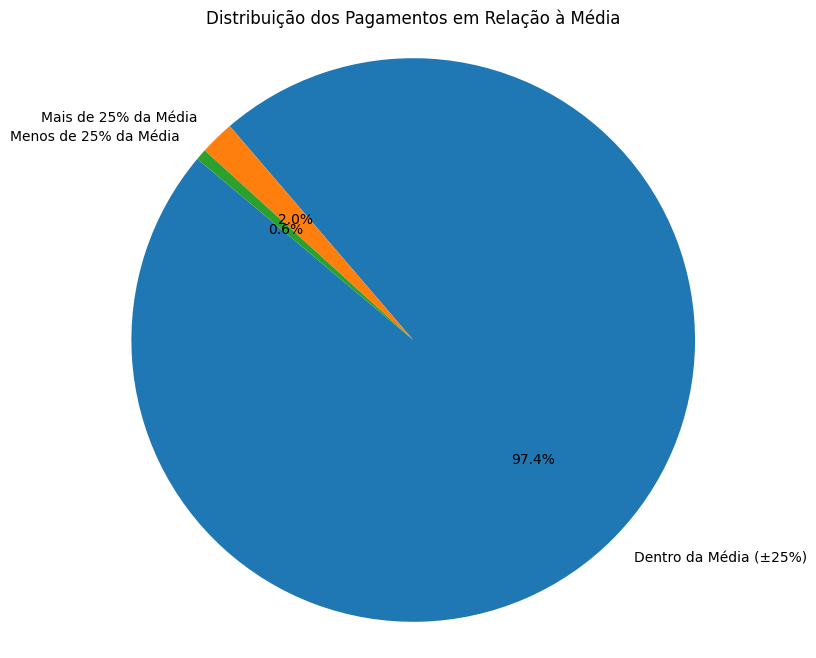

In [16]:
# Calcular a média do Valor de Venda
media_valor_venda = union_df_pd['Valor de Venda'].mean()

# Definir as faixas
def categorizar_valor(valor):
    if valor < media_valor_venda * 0.75:  # Menos de 25% da média
        return 'Menos de 25% da Média'
    elif valor <= media_valor_venda * 1.25:  # Dentro da média (±25%)
        return 'Dentro da Média (±25%)'
    else:  # Mais de 25% da média
        return 'Mais de 25% da Média'

# Aplicar a função para categorizar os valores
union_df_pd['Categoria'] = union_df_pd['Valor de Venda'].apply(categorizar_valor)

# Contar as ocorrências em cada categoria
contagem_categorias = union_df_pd['Categoria'].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(contagem_categorias, labels=contagem_categorias.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição dos Pagamentos em Relação à Média')
plt.axis('equal')  # Para garantir que o gráfico seja um círculo
plt.show()

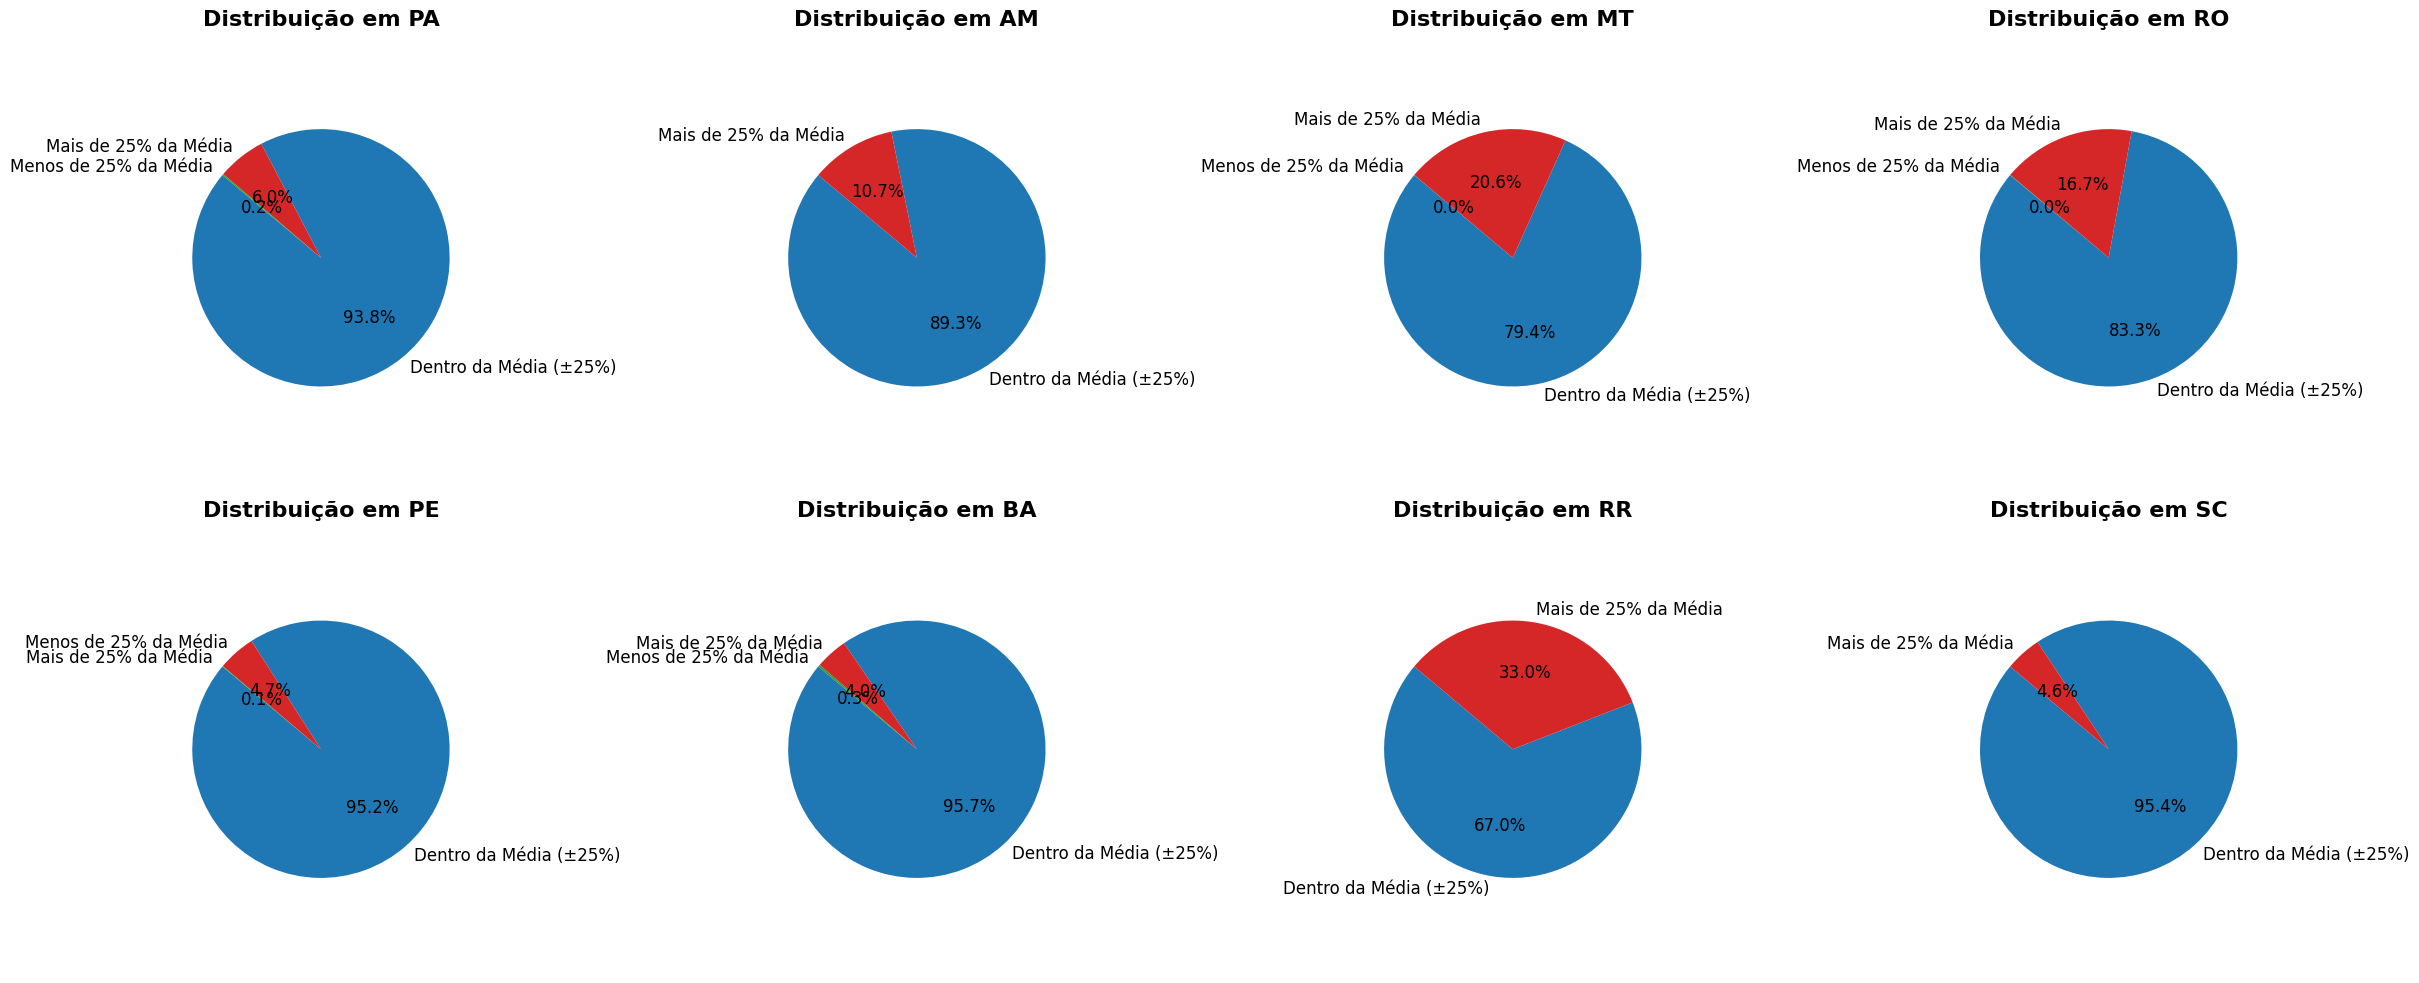

In [17]:
# Aplicar a função para categorizar os valores
union_df_pd['Categoria'] = union_df_pd['Valor de Venda'].apply(categorizar_valor)
estados_desejados = ['BA', 'PE', 'PA', 'RR', 'RO', 'SC', 'MT','AM']
union_df_filtered = union_df_pd[union_df_pd['Estado - Sigla'].isin(estados_desejados)]

# Obter a lista de estados únicos filtrados
estados = union_df_filtered['Estado - Sigla'].unique()

# Cores para cada categoria (cores mais vivas)
cores = ['#1f77b4','#d62728', '#2ca02c']  # azul, verde e vermelho

# Criar subplots para os gráficos de pizza
num_estados = len(estados)
num_colunas = 4
num_linhas = (num_estados + num_colunas - 1) // num_colunas  # Número de linhas necessárias

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(24, num_linhas * 5))
axs = axs.flatten()  # Facilita o acesso aos eixos

# Criar gráficos de pizza para cada estado
for i, estado in enumerate(estados):
    contagem_categorias = union_df_filtered[union_df_filtered['Estado - Sigla'] == estado]['Categoria'].value_counts()

    axs[i].pie(contagem_categorias, labels=contagem_categorias.index, autopct='%1.1f%%', startangle=140, colors=cores)
    axs[i].set_title(f'Distribuição em {estado}', fontsize=16, fontweight='bold')  # Título saliente
    axs[i].axis('equal')  # Para garantir que o gráfico seja um círculo

    # Melhorar a legibilidade do texto
    for text in axs[i].texts:
        text.set_fontsize(12)  # Aumentar o tamanho da fonte

# Remover eixos não utilizados
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [18]:
union_df_pd['Valor de Venda'].mean()

104.57461843389068

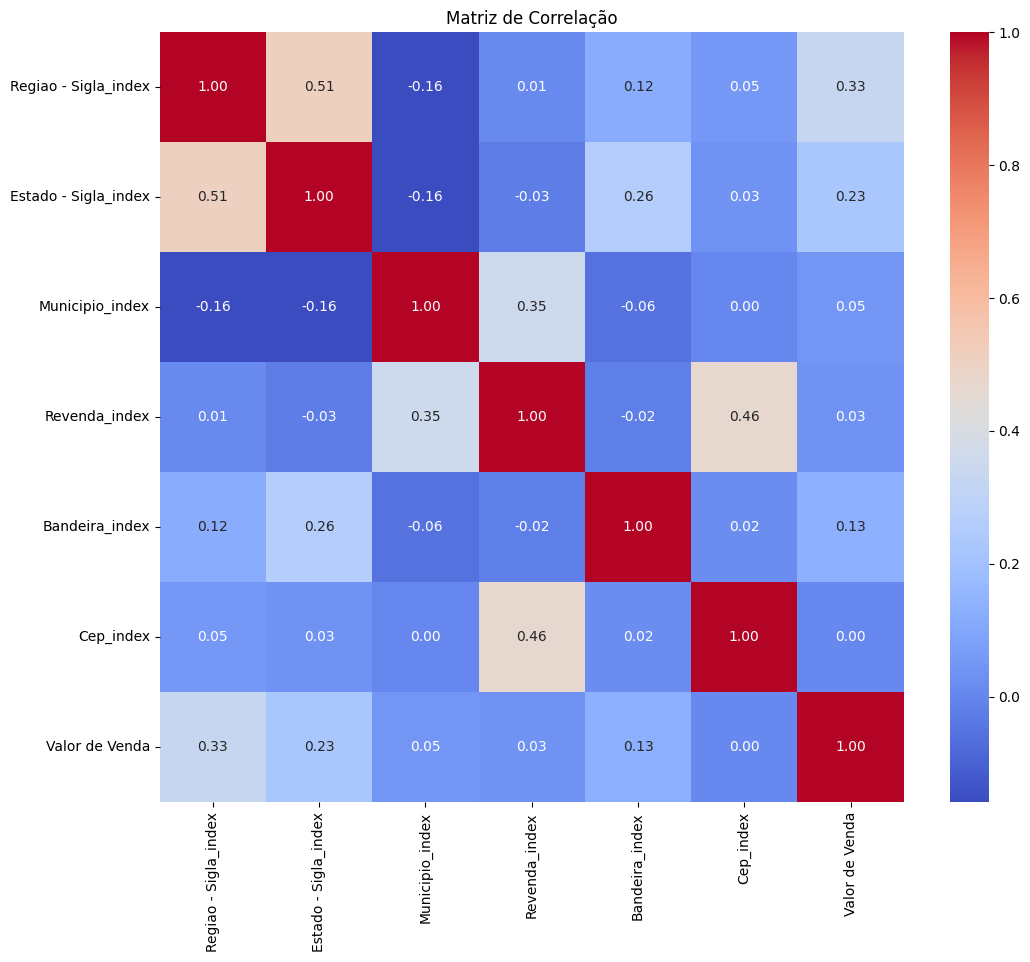

In [19]:
from pyspark.ml.feature import StringIndexer
## Definindo as colunas categóricas e numéricas
categorical_cols = ['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda', 'Bandeira', 'Cep']
numerical_cols = ['Valor de Venda']

# Verificando se todas as colunas categóricas existem no DataFrame
missing_cols = [col for col in categorical_cols if col not in union_df.columns]
if missing_cols:
    print(f"As seguintes colunas estão ausentes: {missing_cols}")
else:
    # Transformando variáveis categóricas em numéricas
    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip") for col in categorical_cols]
    for indexer in indexers:
        union_df = indexer.fit(union_df).transform(union_df)

    df_indexed = union_df.select([F.col(f"{col}_index") for col in categorical_cols] + [F.col(col) for col in numerical_cols])

    # Convertendo para DataFrame do Pandas para plotar a matriz de correlação
    df_pandas = df_indexed.toPandas()
    df_pandas['Valor de Venda'] = df_pandas['Valor de Venda'].str.replace(',', '.').astype(float)

    correlation_matrix = df_pandas.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matriz de Correlação')
    plt.show()